In this notebook, we try to classify X-ray images to classify if a patient has pneumonia or not instead of trying to classify symtomatic COVID-19 altogether. I will use Tensorflow version 2.6.0

Load Tensorflow

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from PIL import Image
import pathlib

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import utils
from tensorflow.keras import Model

batch_size = 32

TensorFlow version: 2.6.0


Load my custom helper functions and preview the data

In [2]:
from src.datareader import get_metadata, get_summary_data
from src.find_images_without_metadata import find_images_without_metadata
from src.labelenums import Label

In [3]:
metadata: pd.DataFrame = get_metadata()
summarydata: pd.DataFrame = get_summary_data()
print(summarydata)

      Label Label_2_Virus_category Label_1_Virus_category  Image_Count
0    Normal                                                       1576
1  Pnemonia         Stress-Smoking                   ARDS            2
2  Pnemonia                  Virus                                1493
3  Pnemonia                  Virus               COVID-19           58
4  Pnemonia                  Virus                   SARS            4
5  Pnemonia               bacteria                                2772
6  Pnemonia               bacteria          Streptococcus            5


In [4]:
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,,
1,IM-0127-0001.jpeg,Normal,TRAIN,,
2,IM-0125-0001.jpeg,Normal,TRAIN,,
3,IM-0122-0001.jpeg,Normal,TRAIN,,
4,IM-0119-0001.jpeg,Normal,TRAIN,,


Let's verify that all the images are in the metadata, else we could run into issues if not careful. If you run into any problems, stop here and fix them.

In [5]:
for dataset in ['TRAIN', 'TEST']:
    extra_files = find_images_without_metadata(dataset)
    if len(extra_files) == 0:
        continue
    for file_name in extra_files:
        fullname = os.path.join(os.getcwd(), 'dataset', dataset, file_name)
        if os.path.isfile(fullname):
            print('Removing file: ' + fullname)
            os.remove(fullname)
    find_images_without_metadata(dataset)


Both lists match for the TRAIN dataset
Both lists match for the TEST dataset


Separate between training and testing

In [6]:
train_sample = metadata.loc[metadata['Dataset_type'] == 'TRAIN']
test_sample = metadata.loc[metadata['Dataset_type'] == 'TEST']
train_path = os.path.join(os.getcwd(), 'dataset', 'TRAIN')
test_path = os.path.join(os.getcwd(), 'dataset', 'TEST')

Preview some images in the training data

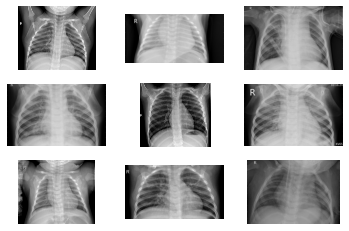

In [7]:
fig, axes = plt.subplots(3, 3, squeeze=False, )
random_image_indices = random.sample(range(len(train_sample)), 9)
image_names = list(train_sample.iloc[random_image_indices]['X_ray_image_name'])
for n in range(9):
    this_axis = axes[n//3, n%3]
    filename = os.path.join(train_path, image_names[n])
    img = mpimg.imread(filename)
    imgplot = this_axis.imshow(img, cmap='gray')
    this_axis.axis('off')


As you can see, the images are not uniform in shape, so we still have some preprocessing to do

In [8]:
image_size_counter = {}
for basename in train_sample['X_ray_image_name']:
    filename = os.path.join(train_path, basename)
    size = Image.open(filename).size
    if size in image_size_counter.keys():
        image_size_counter[(size, size[0] * size[1])] += 1
    else:
        image_size_counter[(size, size[0] * size[1])] = 1
smallest_picture_index = np.argmin([x[1] for x in list(image_size_counter.keys())])
largest_picture_index = np.argmax([x[1] for x in list(image_size_counter.keys())])
print('Smallest image size: ', list(image_size_counter.keys())[smallest_picture_index][0])
print('Large image size: ', list(image_size_counter.keys())[largest_picture_index][0])

Smallest image size:  (384, 127)
Large image size:  (4248, 3480)


Since the images differ widely in size, we must resort to resizing them and normalizing them.

In [9]:
new_size = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
class_names = np.unique(np.array(train_sample['Label']))
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
labeler = Label()


def get_train_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = train_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return [label_int]


def get_test_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = test_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return [label_int]


def process_path(file_path, label):
    img1 = tf.io.read_file(file_path)
    img2 = tf.io.decode_png(img1, channels=1)
    img3 = tf.image.resize(img2, new_size, method='lanczos3', antialias=True)
    img4 = normalization_layer(img3)
    return img4, label


In [14]:
train_images = os.listdir(train_path)
num_train_images = len(train_images)
# train_image_indices = np.arange(num_train_images)
# np.random.shuffle(train_image_indices)
train_images_fullpaths = [
    os.path.join(train_path, image_name)
    for image_name in train_images
]

test_images = os.listdir(test_path)
num_test_images = len(test_images)
# test_image_indices = np.arange(num_test_images)
# np.random.shuffle(test_image_indices)
test_images_fullpaths = [
    os.path.join(test_path, image_name) 
    for image_name in test_images
]

train_labels = np.array([get_train_label(x) for x in train_images_fullpaths], 
                        dtype=int)
test_labels = np.array([get_test_label(x) for x in test_images_fullpaths], 
                       dtype=int)

In [15]:
for index in range(num_train_images):
    print(train_images[index], get_train_label(train_images[index]))

01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg [1]
1-s2.0-S0140673620303706-fx1_lrg.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-a.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-b.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-c.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-d.jpg [1]
1-s2.0-S1684118220300608-main.pdf-001.jpg [1]
1-s2.0-S1684118220300608-main.pdf-002.jpg [1]
1-s2.0-S1684118220300682-main.pdf-002-a1.png [1]
1-s2.0-S1684118220300682-main.pdf-002-a2.png [1]
1-s2.0-S1684118220300682-main.pdf-003-b1.png [1]
1-s2.0-S1684118220300682-main.pdf-003-b2.png [1]
1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg [1]
171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg [1]
1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg [1]
23E99E2E-447C-46E5-8EB2-D35D12473C39.png [1]
2C10A413-AABE-4807-8CCE-6A2025594067.jpeg [1]
2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg [1]
31BA3780-2323-493F-8AED-62081B9C383B.jpeg [1]
35AF5C3B-D04D-4B4B-92B7-CB1F67D83085.jpeg [1]
39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg [1]
41591_2020_819_Fig1_HTML.webp-day10.png 

IM-0535-0001.jpeg [0]
IM-0536-0001.jpeg [0]
IM-0537-0001.jpeg [0]
IM-0538-0001.jpeg [0]
IM-0539-0001-0001.jpeg [0]
IM-0539-0001-0002.jpeg [0]
IM-0539-0001.jpeg [0]
IM-0540-0001.jpeg [0]
IM-0541-0001.jpeg [0]
IM-0542-0001.jpeg [0]
IM-0543-0001-0002.jpeg [0]
IM-0543-0001.jpeg [0]
IM-0544-0001.jpeg [0]
IM-0545-0001-0001.jpeg [0]
IM-0545-0001-0002.jpeg [0]
IM-0545-0001.jpeg [0]
IM-0546-0001.jpeg [0]
IM-0547-0001.jpeg [0]
IM-0548-0001.jpeg [0]
IM-0549-0001-0001.jpeg [0]
IM-0549-0001-0002.jpeg [0]
IM-0549-0001.jpeg [0]
IM-0551-0001-0001.jpeg [0]
IM-0551-0001-0002.jpeg [0]
IM-0551-0001.jpeg [0]
IM-0552-0001.jpeg [0]
IM-0553-0001-0001.jpeg [0]
IM-0553-0001-0002.jpeg [0]
IM-0553-0001-0003.jpeg [0]
IM-0553-0001.jpeg [0]
IM-0554-0001.jpeg [0]
IM-0555-0001-0001.jpeg [0]
IM-0555-0001-0002.jpeg [0]
IM-0555-0001.jpeg [0]
IM-0556-0001.jpeg [0]
IM-0557-0001.jpeg [0]
IM-0559-0001.jpeg [0]
IM-0560-0001.jpeg [0]
IM-0561-0001.jpeg [0]
IM-0562-0001.jpeg [0]
IM-0563-0001.jpeg [0]
IM-0564-0001.jpeg [0]
IM-056

NORMAL2-IM-0587-0001-0001.jpeg [0]
NORMAL2-IM-0587-0001-0002.jpeg [0]
NORMAL2-IM-0587-0001.jpeg [0]
NORMAL2-IM-0588-0001.jpeg [0]
NORMAL2-IM-0589-0001.jpeg [0]
NORMAL2-IM-0592-0001.jpeg [0]
NORMAL2-IM-0594-0001.jpeg [0]
NORMAL2-IM-0595-0001.jpeg [0]
NORMAL2-IM-0596-0001.jpeg [0]
NORMAL2-IM-0599-0001.jpeg [0]
NORMAL2-IM-0600-0001.jpeg [0]
NORMAL2-IM-0601-0001.jpeg [0]
NORMAL2-IM-0602-0001.jpeg [0]
NORMAL2-IM-0603-0001.jpeg [0]
NORMAL2-IM-0604-0001.jpeg [0]
NORMAL2-IM-0609-0001.jpeg [0]
NORMAL2-IM-0611-0001.jpeg [0]
NORMAL2-IM-0616-0001.jpeg [0]
NORMAL2-IM-0617-0001.jpeg [0]
NORMAL2-IM-0618-0001.jpeg [0]
NORMAL2-IM-0619-0001.jpeg [0]
NORMAL2-IM-0620-0001.jpeg [0]
NORMAL2-IM-0621-0001.jpeg [0]
NORMAL2-IM-0622-0001.jpeg [0]
NORMAL2-IM-0623-0001.jpeg [0]
NORMAL2-IM-0626-0001.jpeg [0]
NORMAL2-IM-0627-0001.jpeg [0]
NORMAL2-IM-0629-0001.jpeg [0]
NORMAL2-IM-0630-0001.jpeg [0]
NORMAL2-IM-0633-0001.jpeg [0]
NORMAL2-IM-0634-0001.jpeg [0]
NORMAL2-IM-0635-0001.jpeg [0]
NORMAL2-IM-0636-0001.jpeg [0]


NORMAL2-IM-1152-0001-0002.jpeg [0]
NORMAL2-IM-1152-0001.jpeg [0]
NORMAL2-IM-1153-0001.jpeg [0]
NORMAL2-IM-1154-0001-0001.jpeg [0]
NORMAL2-IM-1154-0001-0002.jpeg [0]
NORMAL2-IM-1154-0001.jpeg [0]
NORMAL2-IM-1155-0001.jpeg [0]
NORMAL2-IM-1156-0001.jpeg [0]
NORMAL2-IM-1157-0001.jpeg [0]
NORMAL2-IM-1158-0001.jpeg [0]
NORMAL2-IM-1160-0001.jpeg [0]
NORMAL2-IM-1161-0001.jpeg [0]
NORMAL2-IM-1162-0001.jpeg [0]
NORMAL2-IM-1163-0001.jpeg [0]
NORMAL2-IM-1164-0001.jpeg [0]
NORMAL2-IM-1167-0001.jpeg [0]
NORMAL2-IM-1168-0001.jpeg [0]
NORMAL2-IM-1169-0001.jpeg [0]
NORMAL2-IM-1170-0001.jpeg [0]
NORMAL2-IM-1171-0001.jpeg [0]
NORMAL2-IM-1173-0001.jpeg [0]
NORMAL2-IM-1174-0001.jpeg [0]
NORMAL2-IM-1175-0001.jpeg [0]
NORMAL2-IM-1176-0001.jpeg [0]
NORMAL2-IM-1177-0001.jpeg [0]
NORMAL2-IM-1178-0001.jpeg [0]
NORMAL2-IM-1179-0001.jpeg [0]
NORMAL2-IM-1180-0001.jpeg [0]
NORMAL2-IM-1181-0001.jpeg [0]
NORMAL2-IM-1182-0001.jpeg [0]
NORMAL2-IM-1183-0001.jpeg [0]
NORMAL2-IM-1184-0001.jpeg [0]
NORMAL2-IM-1185-0001.jpeg

person1048_bacteria_2982.jpeg [1]
person1048_virus_1744.jpeg [1]
person1049_bacteria_2983.jpeg [1]
person1049_virus_1746.jpeg [1]
person104_virus_191.jpeg [1]
person1050_bacteria_2984.jpeg [1]
person1051_bacteria_2985.jpeg [1]
person1051_virus_1750.jpeg [1]
person1052_bacteria_2986.jpeg [1]
person1052_virus_1751.jpeg [1]
person1053_bacteria_2987.jpeg [1]
person1054_bacteria_2988.jpeg [1]
person1055_bacteria_2989.jpeg [1]
person1056_bacteria_2990.jpeg [1]
person1056_virus_1755.jpeg [1]
person1057_bacteria_2991.jpeg [1]
person1057_virus_1756.jpeg [1]
person1058_bacteria_2992.jpeg [1]
person1058_virus_1757.jpeg [1]
person1059_bacteria_2993.jpeg [1]
person1059_virus_1758.jpeg [1]
person105_virus_192.jpeg [1]
person105_virus_193.jpeg [1]
person1060_virus_1760.jpeg [1]
person1062_bacteria_2996.jpeg [1]
person1062_virus_1762.jpeg [1]
person1063_bacteria_2997.jpeg [1]
person1063_virus_1765.jpeg [1]
person1065_bacteria_2999.jpeg [1]
person1065_virus_1768.jpeg [1]
person1066_bacteria_3000.jpeg [

person1180_virus_2009.jpeg [1]
person1180_virus_2010.jpeg [1]
person1180_virus_2011.jpeg [1]
person1180_virus_2012.jpeg [1]
person1180_virus_2013.jpeg [1]
person1180_virus_2014.jpeg [1]
person1180_virus_2015.jpeg [1]
person1181_bacteria_3129.jpeg [1]
person1181_virus_2016.jpeg [1]
person1182_virus_2017.jpeg [1]
person1183_bacteria_3131.jpeg [1]
person1183_virus_2018.jpeg [1]
person1184_bacteria_3132.jpeg [1]
person1184_virus_2019.jpeg [1]
person1185_bacteria_3133.jpeg [1]
person1186_bacteria_3134.jpeg [1]
person1186_bacteria_3135.jpeg [1]
person1186_virus_2021.jpeg [1]
person1186_virus_2022.jpeg [1]
person1187_bacteria_3136.jpeg [1]
person1187_virus_2023.jpeg [1]
person1188_bacteria_3137.jpeg [1]
person1188_virus_2024.jpeg [1]
person118_virus_224.jpeg [1]
person1190_virus_2031.jpeg [1]
person1191_virus_2032.jpeg [1]
person1192_bacteria_3141.jpeg [1]
person1193_virus_2034.jpeg [1]
person1194_bacteria_3143.jpeg [1]
person1195_bacteria_3144.jpeg [1]
person1196_bacteria_3146.jpeg [1]
perso

person1311_virus_2257.jpeg [1]
person1311_virus_2259.jpeg [1]
person1312_bacteria_3313.jpeg [1]
person1312_bacteria_3314.jpeg [1]
person1312_bacteria_3316.jpeg [1]
person1312_bacteria_3317.jpeg [1]
person1312_bacteria_3318.jpeg [1]
person1312_bacteria_3319.jpeg [1]
person1312_virus_2261.jpeg [1]
person1313_bacteria_3320.jpeg [1]
person1313_virus_2264.jpeg [1]
person1314_virus_2266.jpeg [1]
person1314_virus_2268.jpeg [1]
person1314_virus_2269.jpeg [1]
person1315_bacteria_3322.jpeg [1]
person1315_virus_2270.jpeg [1]
person1316_bacteria_3326.jpeg [1]
person1316_virus_2271.jpeg [1]
person1317_bacteria_3332.jpeg [1]
person1317_virus_2273.jpeg [1]
person1318_bacteria_3334.jpeg [1]
person1318_bacteria_3335.jpeg [1]
person1318_virus_2274.jpeg [1]
person1319_virus_2276.jpeg [1]
person131_virus_265.jpeg [1]
person1320_bacteria_3339.jpeg [1]
person1320_bacteria_3340.jpeg [1]
person1320_bacteria_3342.jpeg [1]
person1320_bacteria_3344.jpeg [1]
person1320_bacteria_3345.jpeg [1]
person1320_bacteria_3

person1415_bacteria_3629.jpeg [1]
person1415_virus_2425.jpeg [1]
person1416_virus_2427.jpeg [1]
person1417_bacteria_3635.jpeg [1]
person1418_bacteria_3636.jpeg [1]
person1418_bacteria_3637.jpeg [1]
person1418_bacteria_3638.jpeg [1]
person1418_bacteria_3639.jpeg [1]
person1418_bacteria_3643.jpeg [1]
person1418_virus_2429.jpeg [1]
person1419_bacteria_3645.jpeg [1]
person141_virus_287.jpeg [1]
person1420_bacteria_3647.jpeg [1]
person1420_virus_2431.jpeg [1]
person1422_bacteria_3649.jpeg [1]
person1422_virus_2434.jpeg [1]
person1423_bacteria_3650.jpeg [1]
person1424_bacteria_3651.jpeg [1]
person1424_virus_2437.jpeg [1]
person1425_virus_2438.jpeg [1]
person1426_bacteria_3667.jpeg [1]
person1426_bacteria_3668.jpeg [1]
person1426_virus_2439.jpeg [1]
person1427_virus_2441.jpeg [1]
person1428_virus_2442.jpeg [1]
person1429_bacteria_3688.jpeg [1]
person1429_bacteria_3690.jpeg [1]
person1429_bacteria_3691.jpeg [1]
person1429_virus_2443.jpeg [1]
person142_virus_288.jpeg [1]
person1430_bacteria_369

person1520_virus_2647.jpeg [1]
person1521_virus_2649.jpeg [1]
person1522_bacteria_3977.jpeg [1]
person1522_virus_2651.jpeg [1]
person1523_bacteria_3979.jpeg [1]
person1523_bacteria_3980.jpeg [1]
person1524_bacteria_3983.jpeg [1]
person1524_bacteria_3984.jpeg [1]
person1524_virus_2658.jpeg [1]
person1525_bacteria_3985.jpeg [1]
person1525_virus_2659.jpeg [1]
person1526_bacteria_3986.jpeg [1]
person1526_virus_2660.jpeg [1]
person1527_bacteria_3988.jpeg [1]
person1527_bacteria_3989.jpeg [1]
person1527_bacteria_3990.jpeg [1]
person1527_virus_2661.jpeg [1]
person1528_bacteria_3991.jpeg [1]
person1528_bacteria_3996.jpeg [1]
person1528_virus_2662.jpeg [1]
person1529_virus_2663.jpeg [1]
person152_virus_303.jpeg [1]
person1530_bacteria_4000.jpeg [1]
person1530_virus_2664.jpeg [1]
person1531_bacteria_4003.jpeg [1]
person1531_virus_2666.jpeg [1]
person1532_virus_2667.jpeg [1]
person1534_virus_2670.jpeg [1]
person1535_bacteria_4015.jpeg [1]
person1535_bacteria_4016.jpeg [1]
person1535_bacteria_4017

person1668_bacteria_4420.jpeg [1]
person1668_bacteria_4421.jpeg [1]
person1669_bacteria_4422.jpeg [1]
person1669_bacteria_4423.jpeg [1]
person1669_bacteria_4424.jpeg [1]
person1670_bacteria_4425.jpeg [1]
person1670_bacteria_4426.jpeg [1]
person1670_bacteria_4427.jpeg [1]
person1670_bacteria_4428.jpeg [1]
person1670_bacteria_4429.jpeg [1]
person1670_bacteria_4430.jpeg [1]
person1670_bacteria_4431.jpeg [1]
person1671_bacteria_4432.jpeg [1]
person1673_bacteria_4434.jpeg [1]
person1674_bacteria_4437.jpeg [1]
person1676_bacteria_4441.jpeg [1]
person1677_bacteria_4443.jpeg [1]
person1677_bacteria_4444.jpeg [1]
person1678_bacteria_4446.jpeg [1]
person1679_bacteria_4448.jpeg [1]
person1679_bacteria_4449.jpeg [1]
person1679_bacteria_4450.jpeg [1]
person1679_bacteria_4452.jpeg [1]
person1679_bacteria_4453.jpeg [1]
person1680_bacteria_4455.jpeg [1]
person1682_bacteria_4459.jpeg [1]
person1683_bacteria_4460.jpeg [1]
person1684_bacteria_4461.jpeg [1]
person1684_bacteria_4462.jpeg [1]
person1684_bac

person24_bacteria_108.jpeg [1]
person24_bacteria_109.jpeg [1]
person24_bacteria_110.jpeg [1]
person24_bacteria_111.jpeg [1]
person24_bacteria_112.jpeg [1]
person253_bacteria_1152.jpeg [1]
person253_bacteria_1153.jpeg [1]
person253_bacteria_1154.jpeg [1]
person253_bacteria_1155.jpeg [1]
person253_bacteria_1156.jpeg [1]
person253_bacteria_1157.jpeg [1]
person255_bacteria_1160.jpeg [1]
person255_bacteria_1161.jpeg [1]
person255_bacteria_1162.jpeg [1]
person255_bacteria_1165.jpeg [1]
person255_bacteria_1175.jpeg [1]
person255_bacteria_1182.jpeg [1]
person255_bacteria_1188.jpeg [1]
person255_virus_531.jpeg [1]
person256_bacteria_1189.jpeg [1]
person256_virus_537.jpeg [1]
person257_bacteria_1191.jpeg [1]
person257_bacteria_1193.jpeg [1]
person257_bacteria_1194.jpeg [1]
person257_bacteria_1195.jpeg [1]
person257_bacteria_1196.jpeg [1]
person257_bacteria_1197.jpeg [1]
person257_bacteria_1199.jpeg [1]
person257_bacteria_1200.jpeg [1]
person257_virus_538.jpeg [1]
person258_bacteria_1205.jpeg [1]

person309_virus_631.jpeg [1]
person309_virus_632.jpeg [1]
person30_bacteria_145.jpeg [1]
person30_bacteria_146.jpeg [1]
person30_bacteria_147.jpeg [1]
person30_bacteria_148.jpeg [1]
person30_bacteria_149.jpeg [1]
person30_bacteria_150.jpeg [1]
person30_bacteria_151.jpeg [1]
person30_bacteria_152.jpeg [1]
person30_bacteria_153.jpeg [1]
person30_bacteria_154.jpeg [1]
person30_bacteria_155.jpeg [1]
person30_bacteria_156.jpeg [1]
person30_bacteria_157.jpeg [1]
person30_bacteria_158.jpeg [1]
person310_bacteria_1450.jpeg [1]
person310_bacteria_1451.jpeg [1]
person310_virus_633.jpeg [1]
person311_bacteria_1452.jpeg [1]
person311_bacteria_1453.jpeg [1]
person311_virus_634.jpeg [1]
person312_bacteria_1454.jpeg [1]
person312_bacteria_1455.jpeg [1]
person312_bacteria_1456.jpeg [1]
person312_virus_635.jpeg [1]
person313_bacteria_1457.jpeg [1]
person313_bacteria_1458.jpeg [1]
person313_bacteria_1459.jpeg [1]
person313_bacteria_1460.jpeg [1]
person313_virus_637.jpeg [1]
person314_bacteria_1461.jpeg 

person370_bacteria_1689.jpeg [1]
person370_bacteria_1690.jpeg [1]
person370_bacteria_1691.jpeg [1]
person370_bacteria_1692.jpeg [1]
person370_virus_752.jpeg [1]
person370_virus_753.jpeg [1]
person371_bacteria_1694.jpeg [1]
person371_bacteria_1695.jpeg [1]
person371_bacteria_1696.jpeg [1]
person371_bacteria_1698.jpeg [1]
person371_bacteria_1699.jpeg [1]
person371_bacteria_1700.jpeg [1]
person371_bacteria_1701.jpeg [1]
person371_bacteria_1702.jpeg [1]
person371_bacteria_1703.jpeg [1]
person371_virus_754.jpeg [1]
person372_bacteria_1704.jpeg [1]
person372_bacteria_1705.jpeg [1]
person372_bacteria_1706.jpeg [1]
person372_virus_755.jpeg [1]
person373_bacteria_1707.jpeg [1]
person373_bacteria_1708.jpeg [1]
person373_bacteria_1709.jpeg [1]
person373_virus_756.jpeg [1]
person374_bacteria_1710.jpeg [1]
person374_bacteria_1711.jpeg [1]
person374_bacteria_1712.jpeg [1]
person374_virus_757.jpeg [1]
person375_bacteria_1713.jpeg [1]
person375_virus_758.jpeg [1]
person376_bacteria_1715.jpeg [1]
perso

person469_bacteria_1995.jpeg [1]
person469_virus_965.jpeg [1]
person46_bacteria_224.jpeg [1]
person46_bacteria_225.jpeg [1]
person470_bacteria_1996.jpeg [1]
person470_bacteria_1998.jpeg [1]
person470_bacteria_1999.jpeg [1]
person470_bacteria_2000.jpeg [1]
person470_bacteria_2001.jpeg [1]
person470_bacteria_2002.jpeg [1]
person470_bacteria_2003.jpeg [1]
person470_virus_966.jpeg [1]
person471_bacteria_2004.jpeg [1]
person471_bacteria_2005.jpeg [1]
person471_bacteria_2006.jpeg [1]
person471_virus_967.jpeg [1]
person471_virus_968.jpeg [1]
person472_bacteria_2007.jpeg [1]
person472_bacteria_2008.jpeg [1]
person472_bacteria_2010.jpeg [1]
person472_bacteria_2014.jpeg [1]
person472_bacteria_2015.jpeg [1]
person472_virus_969.jpeg [1]
person473_bacteria_2018.jpeg [1]
person474_virus_971.jpeg [1]
person475_bacteria_2020.jpeg [1]
person475_bacteria_2021.jpeg [1]
person475_bacteria_2022.jpeg [1]
person475_bacteria_2023.jpeg [1]
person475_bacteria_2024.jpeg [1]
person475_bacteria_2025.jpeg [1]
perso

person534_bacteria_2253.jpeg [1]
person534_bacteria_2254.jpeg [1]
person534_virus_1061.jpeg [1]
person535_bacteria_2255.jpeg [1]
person535_bacteria_2256.jpeg [1]
person535_virus_1062.jpeg [1]
person536_bacteria_2257.jpeg [1]
person536_bacteria_2258.jpeg [1]
person536_bacteria_2259.jpeg [1]
person536_bacteria_2260.jpeg [1]
person536_virus_1064.jpeg [1]
person536_virus_1065.jpeg [1]
person537_bacteria_2261.jpeg [1]
person537_bacteria_2262.jpeg [1]
person537_bacteria_2263.jpeg [1]
person537_bacteria_2264.jpeg [1]
person537_bacteria_2265.jpeg [1]
person537_bacteria_2266.jpeg [1]
person537_virus_1067.jpeg [1]
person538_bacteria_2268.jpeg [1]
person538_virus_1068.jpeg [1]
person539_bacteria_2269.jpeg [1]
person539_bacteria_2270.jpeg [1]
person539_virus_1069.jpeg [1]
person53_bacteria_252.jpeg [1]
person53_bacteria_253.jpeg [1]
person53_bacteria_254.jpeg [1]
person53_bacteria_255.jpeg [1]
person540_bacteria_2271.jpeg [1]
person540_bacteria_2272.jpeg [1]
person540_bacteria_2273.jpeg [1]
person

person600_bacteria_2457.jpeg [1]
person600_bacteria_2458.jpeg [1]
person600_virus_1156.jpeg [1]
person601_bacteria_2459.jpeg [1]
person602_bacteria_2460.jpeg [1]
person603_bacteria_2461.jpeg [1]
person603_virus_1164.jpeg [1]
person604_bacteria_2462.jpeg [1]
person604_bacteria_2463.jpeg [1]
person604_virus_1165.jpeg [1]
person605_bacteria_2464.jpeg [1]
person605_bacteria_2465.jpeg [1]
person605_bacteria_2466.jpeg [1]
person605_bacteria_2467.jpeg [1]
person605_bacteria_2468.jpeg [1]
person605_virus_1166.jpeg [1]
person605_virus_1169.jpeg [1]
person606_bacteria_2469.jpeg [1]
person607_bacteria_2470.jpeg [1]
person607_virus_1173.jpeg [1]
person608_bacteria_2471.jpeg [1]
person608_bacteria_2472.jpeg [1]
person608_bacteria_2473.jpeg [1]
person608_virus_1175.jpeg [1]
person609_bacteria_2474.jpeg [1]
person609_virus_1176.jpeg [1]
person60_bacteria_285.jpeg [1]
person60_bacteria_286.jpeg [1]
person60_bacteria_287.jpeg [1]
person610_bacteria_2475.jpeg [1]
person610_virus_1177.jpeg [1]
person611_

person718_virus_1316.jpeg [1]
person719_bacteria_2621.jpeg [1]
person719_virus_1338.jpeg [1]
person71_bacteria_347.jpeg [1]
person71_bacteria_348.jpeg [1]
person71_bacteria_349.jpeg [1]
person71_bacteria_350.jpeg [1]
person71_bacteria_351.jpeg [1]
person720_bacteria_2622.jpeg [1]
person720_virus_1339.jpeg [1]
person721_bacteria_2623.jpeg [1]
person721_virus_1340.jpeg [1]
person722_virus_1341.jpeg [1]
person723_bacteria_2625.jpeg [1]
person723_virus_1342.jpeg [1]
person724_bacteria_2626.jpeg [1]
person724_virus_1343.jpeg [1]
person724_virus_1344.jpeg [1]
person725_bacteria_2627.jpeg [1]
person726_bacteria_2628.jpeg [1]
person727_bacteria_2629.jpeg [1]
person727_virus_1347.jpeg [1]
person728_bacteria_2630.jpeg [1]
person72_bacteria_352.jpeg [1]
person72_bacteria_353.jpeg [1]
person72_bacteria_354.jpeg [1]
person730_bacteria_2632.jpeg [1]
person730_virus_1351.jpeg [1]
person731_bacteria_2633.jpeg [1]
person731_virus_1352.jpeg [1]
person732_bacteria_2634.jpeg [1]
person732_virus_1353.jpeg 

person866_virus_1511.jpeg [1]
person867_bacteria_2789.jpeg [1]
person867_virus_1512.jpeg [1]
person868_virus_1513.jpeg [1]
person868_virus_1514.jpeg [1]
person86_virus_159.jpeg [1]
person870_bacteria_2792.jpeg [1]
person870_virus_1516.jpeg [1]
person871_bacteria_2793.jpeg [1]
person871_virus_1517.jpeg [1]
person872_bacteria_2795.jpeg [1]
person873_bacteria_2796.jpeg [1]
person874_bacteria_2797.jpeg [1]
person875_bacteria_2798.jpeg [1]
person876_bacteria_2799.jpeg [1]
person877_bacteria_2800.jpeg [1]
person877_virus_1525.jpeg [1]
person878_bacteria_2801.jpeg [1]
person878_virus_1526.jpeg [1]
person87_virus_160.jpeg [1]
person880_bacteria_2804.jpeg [1]
person880_virus_1529.jpeg [1]
person881_bacteria_2805.jpeg [1]
person881_virus_1531.jpeg [1]
person882_bacteria_2806.jpeg [1]
person883_bacteria_2807.jpeg [1]
person883_virus_1533.jpeg [1]
person884_bacteria_2808.jpeg [1]
person884_virus_1534.jpeg [1]
person885_bacteria_2809.jpeg [1]
person886_bacteria_2810.jpeg [1]
person886_virus_1536.jp

In [16]:
train_image_paths_tensors = tf.convert_to_tensor(train_images_fullpaths, dtype=tf.string)
train_labels_tensors = tf.convert_to_tensor(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_tensors, train_labels_tensors))
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

test_image_paths_tensors = tf.convert_to_tensor(test_images_fullpaths, dtype=tf.string)
test_labels_tensors = tf.convert_to_tensor(test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths_tensors, test_labels_tensors))
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)


print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

5286
624


In [17]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

In [18]:
metrics = [
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.CosineSimilarity()
#     tf.keras.metrics.Recall(name='recall'),
#     tf.keras.metrics.AUC(name='auc', curve='ROC')
]

In [49]:
filters = 10
kernel_size = (3, 3)
activation = 'relu'
# num_classes = len(class_names)
num_output_layer = 1

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, 
                           kernel_size=kernel_size, 
                           activation=activation,
                           strides=1,
                           padding='valid',
                           input_shape=(new_size[0], new_size[1], 1)),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(num_output_layer)
])

In [50]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=metrics)

In [51]:
checkpoint_path = "training_has_pnemonia/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=2, 
                                                 restore_best_weights=True)


In [52]:
epochs = 10
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[cp_callback, early_stoping]
)

Epoch 1/10
166/166 [==============================] - 69s 413ms/step - loss: 3.7871 - mean_squared_error: 1253.2245 - binary_accuracy: 0.7117 - cosine_similarity: 0.6014 - val_loss: 5.7185 - val_mean_squared_error: 1285.1633 - val_binary_accuracy: 0.6250 - val_cosine_similarity: 0.6250

Epoch 00001: saving model to training_has_pnemonia\cp.ckpt
Epoch 2/10
166/166 [==============================] - 69s 415ms/step - loss: 3.8715 - mean_squared_error: 1321.5212 - binary_accuracy: 0.7461 - cosine_similarity: 0.7461 - val_loss: 5.7185 - val_mean_squared_error: 1285.1635 - val_binary_accuracy: 0.6250 - val_cosine_similarity: 0.6250

Epoch 00002: saving model to training_has_pnemonia\cp.ckpt
Epoch 3/10
166/166 [==============================] - 70s 424ms/step - loss: 3.8715 - mean_squared_error: 1321.7422 - binary_accuracy: 0.7461 - cosine_similarity: 0.7461 - val_loss: 5.7185 - val_mean_squared_error: 1285.1635 - val_binary_accuracy: 0.6250 - val_cosine_similarity: 0.6250

Epoch 00003: savin

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 254, 254, 10)      100       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 10)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 125, 125, 10)      910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 10)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 10)        910       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9000)             

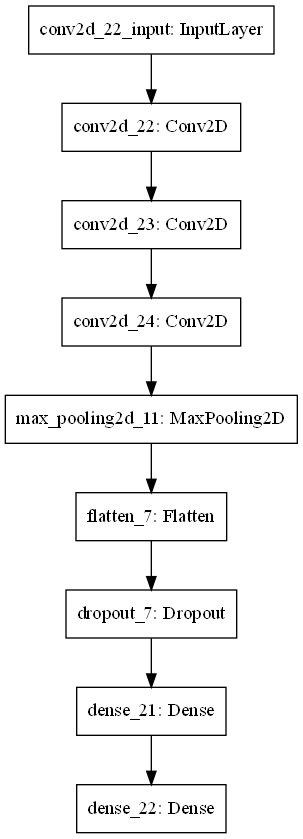

In [53]:
tf.keras.utils.plot_model(model, to_file='model_has_pnemonia.png')